In [29]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler

In [30]:
# Filter rows based on column: 'Series Code'
s = pd.read_csv(r'/Users/gracesaunders/Documents/GitHub/DS3001Project/DS3001Project/WDISeries.csv')
s = s[(s['Series Code'] == "CC.PER.RNK") | (s['Series Code'] == "DT.DOD.DIMF.CD") | (s['Series Code'] == "DT.DOD.PVLX.GN.ZS") | 
      (s['Series Code'] == "FD.AST.PRVT.GD.ZS") | (s['Series Code'] == "FP.CPI.TOTL") | (s['Series Code'] == "GE.PER.RNK") | 
      (s['Series Code'] == "HD.HCI.OVRL") | (s['Series Code'] == "MS.MIL.XPND.ZS") | (s['Series Code'] == "NY.GDP.PCAP.KD") | 
      (s['Series Code'] == "NY.GNP.PCAP.KD") | (s['Series Code'] == "PV.PER.RNK") | (s['Series Code'] == "RL.PER.RNK") | 
      (s['Series Code'] == "SE.ADT.LITR.ZS") | (s['Series Code'] == "SE.ADT.1524.LT.ZS") | (s['Series Code'] == "SE.SEC.NENR.FE") | 
      (s['Series Code'] == "SE.XPD.SECO.PC.ZS") | (s['Series Code'] == "SG.VAW.1549.ZS") | (s['Series Code'] == "SH.DTH.IMRT") | 
      (s['Series Code'] == "SH.DYN.AIDS.ZS") | (s['Series Code'] == "SH.H2O.SMDW.ZS") | (s['Series Code'] == "SH.STA.BASS.ZS") | 
      (s['Series Code'] == "SI.POV.GINI") | (s['Series Code'] == "SI.POV.SOPO") | (s['Series Code'] == "SN.ITK.MSFI.ZS") | 
      (s['Series Code'] == "SP.DYN.IMRT.IN") | (s['Series Code'] == "SP.POP.GROW") | (s['Series Code'] == "VC.IHR.PSRC.FE.P5") | 
      (s['Series Code'] == "VC.IDP.NWCV") | (s['Series Code'] == "VA.PER.RNK")]
codes_to_keep = s.loc[:,'Series Code'].unique()
codes_to_keep

array(['CC.PER.RNK', 'DT.DOD.DIMF.CD', 'DT.DOD.PVLX.GN.ZS',
       'FD.AST.PRVT.GD.ZS', 'FP.CPI.TOTL', 'GE.PER.RNK', 'HD.HCI.OVRL',
       'MS.MIL.XPND.ZS', 'NY.GDP.PCAP.KD', 'NY.GNP.PCAP.KD', 'PV.PER.RNK',
       'RL.PER.RNK', 'SE.ADT.1524.LT.ZS', 'SE.ADT.LITR.ZS',
       'SE.SEC.NENR.FE', 'SE.XPD.SECO.PC.ZS', 'SG.VAW.1549.ZS',
       'SH.DTH.IMRT', 'SH.DYN.AIDS.ZS', 'SH.H2O.SMDW.ZS',
       'SH.STA.BASS.ZS', 'SI.POV.GINI', 'SI.POV.SOPO', 'SN.ITK.MSFI.ZS',
       'SP.DYN.IMRT.IN', 'SP.POP.GROW', 'VA.PER.RNK', 'VC.IDP.NWCV',
       'VC.IHR.PSRC.FE.P5'], dtype=object)

In [31]:
og = pd.read_csv('/Users/gracesaunders/Downloads/World Development Indicators Jan 28 2025 (1)/WDICSV.csv')

In [32]:
target_oda_data = og[og['Indicator Code'] == "DT.ODA.ODAT.KD"]

features = og[og['Indicator Code'].isin(codes_to_keep)]

df_filtered = pd.concat([features, target_oda_data])

df_filtered = df_filtered.loc[:,['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code', '2010', '2011', '2012', '2013', '2014', '2015', '2016', 
                        '2017', '2018', '2019', '2020', '2021']]
df_filtered = df_filtered[df_filtered.index >= 72281]

In [33]:
df_long = df_filtered.melt(
    id_vars=["Country Name", "Country Code", "Indicator Name", "Indicator Code"],
    var_name="Year",
    value_name="Value"
)

df_pivot = df_long.pivot_table(
    index=["Country Name", "Country Code", "Year"],
    columns="Indicator Name",
    values="Value"
).reset_index()

In [34]:
df_pivot = df_pivot[df_pivot['Net official development assistance received (constant 2021 US$)'].notna()]
df_pivot = df_pivot.sort_values(["Country Code", "Year"])

threshold = 0.5*len(df_pivot)
df_cleaned = df_pivot.dropna(axis = 1, thresh = threshold)
df = df_cleaned.copy()

In [35]:
df['target_lag1'] = df.groupby('Country Code')['Net official development assistance received (constant 2021 US$)'].shift(1)
df = df.dropna(subset=['target_lag1'])
df['Year'] = df['Year'].astype(int)

In [36]:
#df = pd.read_csv('pivot_lagged_clean.csv')

In [37]:

# separate features from target 
y = np.arcsinh(df['target_lag1']) # transform because of skew
X = df.drop(columns=['Net official development assistance received (constant 2021 US$)', 'target_lag1', 'Country Name', 'Country Code', 'Year'])

# Handle missing values (same as before)
missing_mask = X.isnull()
X = X.fillna(0)
for col in X.columns[missing_mask.any()]:
    X[f'{col}_missing'] = missing_mask[col].astype(int)

# Time-based split
cutoff = 2018
train_mask = df['Year'] <= cutoff
test_mask = df['Year'] > cutoff

X_train, X_test = X.loc[train_mask], X.loc[test_mask]
y_train, y_test = y.loc[train_mask], y.loc[test_mask]

In [38]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Train RMSE: 2.5529
Test RMSE: 4.7885
Train R²: 0.7729
Test R²: 0.3262


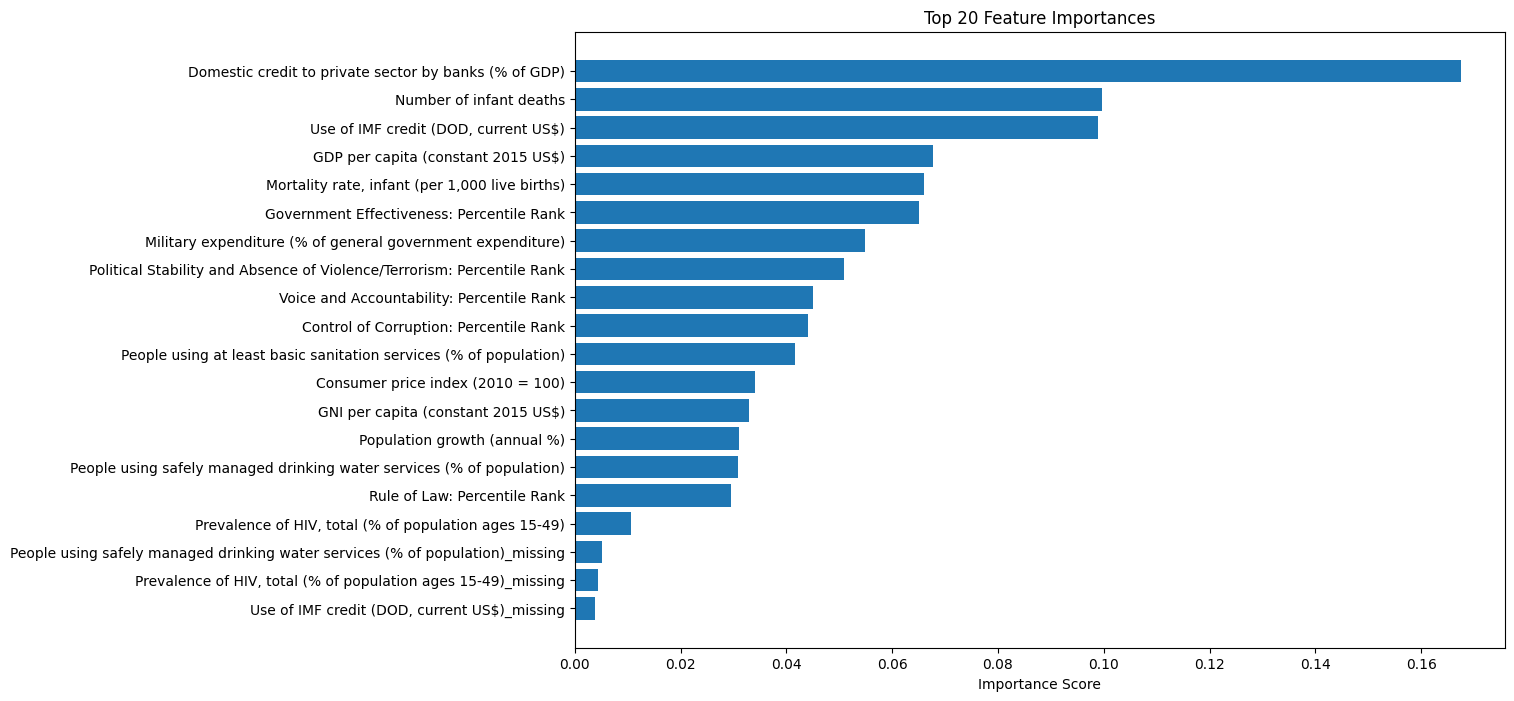

In [40]:
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

## Random Forest Implementation

# Initialize with reasonable defaults
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Fit the model
rf.fit(X_train_scaled, y_train)

# Make predictions
train_pred = rf.predict(X_train_scaled)
test_pred = rf.predict(X_test_scaled)

# Evaluate
print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train, train_pred)):.4f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, test_pred)):.4f}")
print(f"Train R²: {r2_score(y_train, train_pred):.4f}")
print(f"Test R²: {r2_score(y_test, test_pred):.4f}")

## Feature Importance Visualization
feature_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(feature_importances['feature'][:20], feature_importances['importance'][:20])
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance Score')
plt.gca().invert_yaxis()
plt.show()

In [ ]:

# IGNORE BELOW

# 1. Less aggressive PCA
#pca = PCA(n_components=0.9)  # Keep 90% variance
#X_train_pca = pca.fit_transform(X_train_scaled)
#X_test_pca = pca.transform(X_test_scaled)

# 2. Tuned Random Forest
rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=15,
    min_samples_leaf=3,
    max_features='sqrt',
    n_jobs=-1
)
rf.fit(X_train_scaled, y_train)

# 3. Evaluate
test_pred = rf.predict(X_test_scaled)
print(f"Test R²: {r2_score(y_test, test_pred):.2f}")

Test R²: 0.42


In [13]:
import pandas as pd
import numpy as np

# Convert scaled data back to DataFrame (preserving column names)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

# Calculate correlation matrix
corr_matrix = X_train_scaled_df.corr().abs()

# Get upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation > 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

print(f"Dropped {len(to_drop)} highly correlated features:")
print(to_drop)

# Remove correlated features
X_train_reduced = X_train_scaled_df.drop(columns=to_drop)
X_test_reduced = pd.DataFrame(X_test_scaled, columns=X_train.columns).drop(columns=to_drop)

Dropped 5 highly correlated features:
['Control of Corruption: Percentile Rank_missing', 'Government Effectiveness: Percentile Rank_missing', 'Political Stability and Absence of Violence/Terrorism: Percentile Rank_missing', 'Rule of Law: Percentile Rank_missing', 'Voice and Accountability: Percentile Rank_missing']


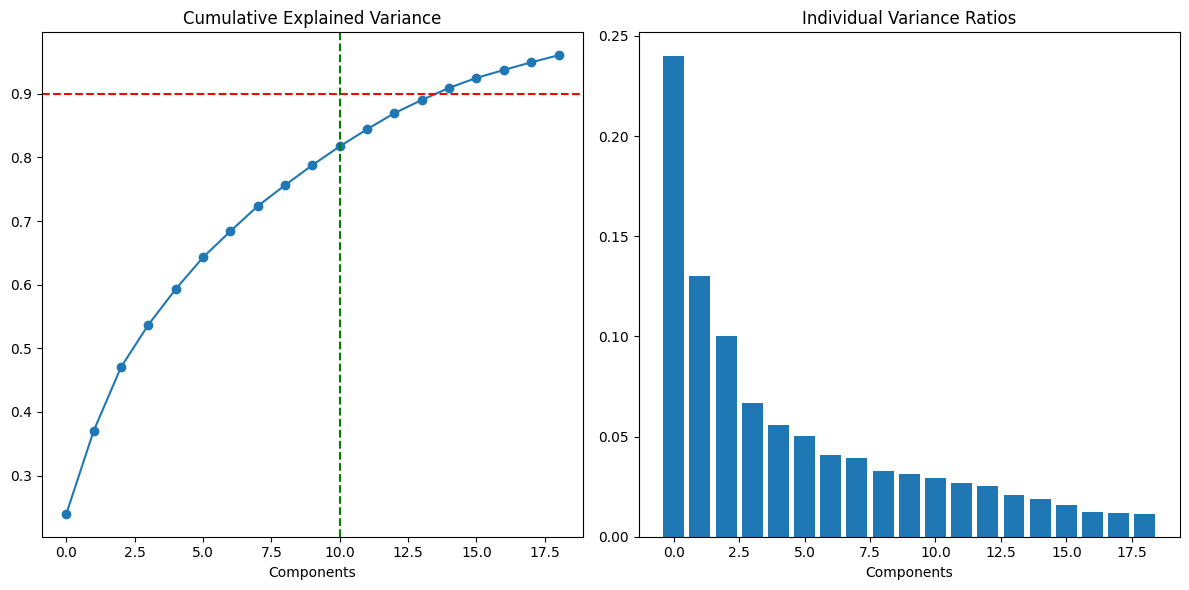

Variance ratios: [0.23981403 0.13038955 0.10014105 0.06664371 0.05600615 0.0500671
 0.0409775  0.03950085 0.03295585 0.03154986 0.02941463 0.02694273
 0.02532353 0.02066388 0.01904931 0.01573036 0.012345   0.01206639
 0.01110338]
Total components needed for 95% variance: 19


In [14]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 3. Run PCA
pca = PCA(n_components=0.95)  # Keep 95% variance
pca.fit(X_train_reduced)

# 4. Plot with diagnostics
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(np.cumsum(pca.explained_variance_ratio_), 'o-')
plt.axhline(0.90, color='r', linestyle='--')
plt.axvline(x=10, color='g', linestyle='--')  # Example elbow at 10 components
plt.title("Cumulative Explained Variance")
plt.xlabel("Components")

plt.subplot(122)
plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
plt.title("Individual Variance Ratios")
plt.xlabel("Components")
plt.tight_layout()
plt.show()

print("Variance ratios:", pca.explained_variance_ratio_)
print("Total components needed for 95% variance:", 
      np.where(np.cumsum(pca.explained_variance_ratio_) >= 0.95)[0][0] + 1)

In [15]:

X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Reduced to {pca.n_components_} components")

Reduced to 18 components


In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

rf_pca = RandomForestRegressor(n_estimators=200, random_state=42)
rf_pca.fit(X_train_pca, y_train)

# Evaluate
pca_train_pred = rf_pca.predict(X_train_pca)
pca_test_pred = rf_pca.predict(X_test_pca)


print(f"PCA-Train R²: {r2_score(y_train, pca_train_pred):.4f}")
print(f"PCA-Test R²: {r2_score(y_test, pca_test_pred):.4f}")

PCA-Train R²: 0.9033
PCA-Test R²: 0.1921


In [68]:
# See which original features contribute most to components
component_df = pd.DataFrame(
    pca.components_,
    columns=X.columns,
    index=[f"PC-{i}" for i in range(1, pca.n_components_+1)]
)

# Show top 3 contributing features per component
for i in range(3):  # First 3 components
    print(f"\nTop features for PC-{i+1}:")
    print(component_df.iloc[i].abs().sort_values(ascending=False).head(5))


Top features for PC-1:
Indicator Name
Number of infant deaths                                                           0.305233
Voice and Accountability: Percentile Rank_missing                                 0.302306
Government Effectiveness: Percentile Rank_missing                                 0.302306
Rule of Law: Percentile Rank_missing                                              0.302306
Political Stability and Absence of Violence/Terrorism: Percentile Rank_missing    0.302306
Name: PC-1, dtype: float64

Top features for PC-2:
Indicator Name
GDP per capita (constant 2015 US$)                                   0.290831
Mortality rate, infant (per 1,000 live births)                       0.247870
People using at least basic sanitation services (% of population)    0.244514
Voice and Accountability: Percentile Rank_missing                    0.244236
Rule of Law: Percentile Rank_missing                                 0.244236
Name: PC-2, dtype: float64

Top features for PC-3:

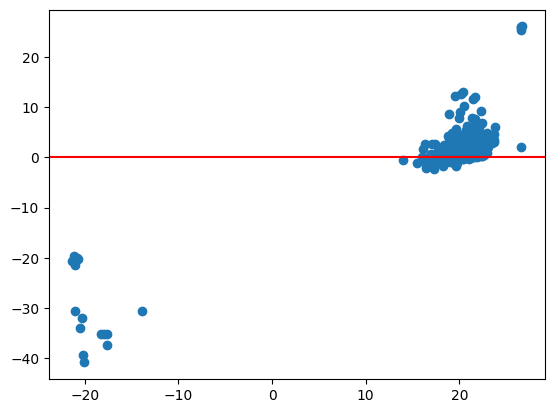

In [49]:
residuals = y_test - rf.predict(X_test_pca)
plt.scatter(y_test, residuals)
plt.axhline(0, color='red')